# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import matplotlib as mpl
plt.rcParams['font.family'] = 'tahoma'
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New', size=10)

In [2]:
df_day = pd.read_csv('/content/drive/MyDrive/CRM_Analytics/hw03-value_proposition/adayinlife.csv')
df_day.head()

,time,activity,pain,gain,stu_id,time_type,time_hr,time_min
0,08.30,ตื่นนอน,ไม่อยากตื่น อยากนอนต่อ,ได้เริ่มต้นวันใหม่,6210422033,NaN,08,30
1,08.35,อาบน้ำ,ยังอยากนอนต่อ,สดชื่น+สะอาด,6210422033,NaN,08,35
2,09.00,กินอาหาเช้า,ต้องสั่ง Delivery,อิ่มท้อง,6210422033,NaN,09,0
3,10.00,เดินทางด้วย BTS ไปทำงาน,ราคาสูง,เดินทางสะดวกสบาย,6210422033,NaN,10,0
4,10.30,ถึงที่ทำงาน เริ่มทำงาน,NaN,เป็นช่วงที่พร้อมทำงานที่สุด,6210422033,NaN,10,30


In [3]:
# for those who want to use simple function --> use only {time_hr}.00-{time_hr+1}.00
def round_time(df, min_round = 60):
  hr = df['time_hr']
  min = df['time_min']
  hr += ( min //min_round )
  return f'{str(hr).zfill(2)}.00-{str(hr+1).zfill(2)}.00'

In [4]:
# clean time
df_day['time_hr'] = df_day['time_hr'].replace('24','0')
df_day['time_hr'] = df_day['time_hr'].astype(int)
df_day['time_min'] = df_day['time_min'].astype(int)
df_day['time_range'] = df_day.apply(round_time,axis=1)

# get activity number
df_day['activity_num'] = df_day.groupby(['stu_id']).cumcount()+1

In [5]:
df_day.head()

,time,activity,pain,gain,stu_id,time_type,time_hr,time_min,time_range,activity_num
0,08.30,ตื่นนอน,ไม่อยากตื่น อยากนอนต่อ,ได้เริ่มต้นวันใหม่,6210422033,NaN,8,30,08.00-09.00,1
1,08.35,อาบน้ำ,ยังอยากนอนต่อ,สดชื่น+สะอาด,6210422033,NaN,8,35,08.00-09.00,2
2,09.00,กินอาหาเช้า,ต้องสั่ง Delivery,อิ่มท้อง,6210422033,NaN,9,0,09.00-10.00,3
3,10.00,เดินทางด้วย BTS ไปทำงาน,ราคาสูง,เดินทางสะดวกสบาย,6210422033,NaN,10,0,10.00-11.00,4
4,10.30,ถึงที่ทำงาน เริ่มทำงาน,NaN,เป็นช่วงที่พร้อมทำงานที่สุด,6210422033,NaN,10,30,10.00-11.00,5


In [6]:
# flag last activity
df_last_act = df_day.groupby(['stu_id'])['activity_num'].max().reset_index()
df_last_act['last_act'] = 1

# merge last activity to df_day
df_day = df_day.merge(df_last_act, on= ['stu_id','activity_num'], how = 'left')

# when BADS student wake
df_wake = df_day[df_day['activity_num']==1][['stu_id','time_range']]
df_wake.columns = ['stu_id','wake_time']

# when BADS student sleep
df_sleep = df_day[df_day['last_act']==1][['stu_id','time_range']]
df_sleep.columns = ['stu_id','sleep_time']

In [7]:
# create df contains stu_id, awake_hr (number of awake time in hr), sleep_hr (number of sleep time in hr)
wake2sleep = df_wake.merge(df_sleep,how='inner', on = 'stu_id')
wake2sleep['wake_time_hr'] = wake2sleep['wake_time'].apply(lambda x:int(x.split('.')[0]))
wake2sleep['sleep_time_hr'] = wake2sleep['sleep_time'].apply(lambda x:int(x.split('.')[0]))
wake2sleep['awake_time'] = wake2sleep['sleep_time_hr'] - wake2sleep['wake_time_hr'] 
wake2sleep['awake_time'] = wake2sleep['awake_time'].apply(lambda x: x+24 if x<=0 else x)
wake2sleep['sleep_time'] = 24 - wake2sleep['awake_time'] 
wake2sleep = wake2sleep[['stu_id','awake_time','sleep_time']].rename(columns = {'awake_time':'awake_hr', 'sleep_time' : 'sleep_hr'})
wake2sleep.head()

,stu_id,awake_hr,sleep_hr
0,6210422033,16,8
1,6210422035,16,8
2,6220422004,18,6
3,6310422093,18,6
4,6310422096,17,7


In [8]:
# something wrong with 5
wake2sleep['awake_hr'].value_counts()

18    18
17    14
19     6
16     6
15     1
5      1
Name: awake_hr, dtype: int64

In [9]:
# something wrong with 19
wake2sleep['sleep_hr'].value_counts()

6     18
7     14
8      6
5      6
19     1
9      1
Name: sleep_hr, dtype: int64

In [10]:
df_day.head()

,time,activity,pain,gain,stu_id,time_type,time_hr,time_min,time_range,activity_num,last_act
0,08.30,ตื่นนอน,ไม่อยากตื่น อยากนอนต่อ,ได้เริ่มต้นวันใหม่,6210422033,NaN,8,30,08.00-09.00,1,NaN
1,08.35,อาบน้ำ,ยังอยากนอนต่อ,สดชื่น+สะอาด,6210422033,NaN,8,35,08.00-09.00,2,NaN
2,09.00,กินอาหาเช้า,ต้องสั่ง Delivery,อิ่มท้อง,6210422033,NaN,9,0,09.00-10.00,3,NaN
3,10.00,เดินทางด้วย BTS ไปทำงาน,ราคาสูง,เดินทางสะดวกสบาย,6210422033,NaN,10,0,10.00-11.00,4,NaN
4,10.30,ถึงที่ทำงาน เริ่มทำงาน,NaN,เป็นช่วงที่พร้อมทำงานที่สุด,6210422033,NaN,10,30,10.00-11.00,5,NaN


# Universal Sentence Encoder (USE)

In [11]:
%tensorflow_version 2.x

In [12]:
!pip install tensorflow_text

In [13]:
import tensorflow_hub as hub
import tensorflow_text
import tensorflow as tf
import json
import itertools

In [14]:
#download open subtitle EN-TH dataset
!wget http://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/moses/en-th.txt.zip

--2021-05-04 01:54:42--  http://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/moses/en-th.txt.zip
Resolving opus.nlpl.eu (opus.nlpl.eu)... 193.166.25.9
Connecting to opus.nlpl.eu (opus.nlpl.eu)|193.166.25.9|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/moses/en-th.txt.zip [following]
--2021-05-04 01:54:43--  https://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/moses/en-th.txt.zip
Connecting to opus.nlpl.eu (opus.nlpl.eu)|193.166.25.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/moses/en-th.txt.zip [following]
--2021-05-04 01:54:43--  https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/moses/en-th.txt.zip
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.19, 86.50.254.18
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.19|:443... connected.
HTTP request sent, awaiting response.

In [15]:
!unzip download.php?f=OpenSubtitles%2Fv2018%2Fmoses%2Fen-th.txt.zip -d data

Archive:  download.php?f=OpenSubtitles%2Fv2018%2Fmoses%2Fen-th.txt.zip
replace data/OpenSubtitles.en-th.en? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/OpenSubtitles.en-th.en  
  inflating: data/OpenSubtitles.en-th.th  
  inflating: data/OpenSubtitles.en-th.ids  
  inflating: data/README             


In [16]:
#Create USE embedding by using tensorflow hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

In [17]:
df_pain = df_day['pain'].astype(str)
df_gain = df_day['gain'].astype(str)

df_use_pain = pd.DataFrame(embed(df_pain.values).numpy(),index= df_pain.values)
df_use_gain = pd.DataFrame(embed(df_gain.values).numpy(),index= df_gain.values)

## Cluster Free Text

In [18]:
pip install umap-learn

In [19]:
import umap
from sklearn.cluster import DBSCAN

In [20]:
df_trans_pain = umap.UMAP(n_neighbors=5, random_state=42).fit_transform(df_use_pain)
df_trans_gain = umap.UMAP(n_neighbors=5, random_state=42).fit_transform(df_use_gain)

In [21]:
# you can adjust eps as you want
label_pain = DBSCAN(eps=1, min_samples=3).fit_predict(df_trans_pain)
label_gain = DBSCAN(eps=1, min_samples=3).fit_predict(df_trans_gain)

In [22]:
df_result_pain = pd.DataFrame({'pain' : df_pain,
                               'cluster' : label_pain})
df_result_gain = pd.DataFrame({'gain' : df_gain,
                               'cluster' : label_gain})

In [23]:
# loop display each cluster number
unq_pain = df_result_pain['cluster'].unique()
unq_pain.sort()
for cluster in unq_pain:
  temp = df_result_pain[df_result_pain['cluster']==cluster]
  display(temp.shape)
  display(temp)

(497, 2)

,pain,cluster
0,ไม่อยากตื่น อยากนอนต่อ,0
2,ต้องสั่ง Delivery,0
5,มีร้านให้เลือกน้อย,0
10,เวลากระชั้นก่อนเลิกงานแค่ 15 นาที,0
11,ยังคิดเกี่ยวกับปัญหางานที่ค้างอยู่,0
...,...,...
910,เสียเวลาในการเตรียมอาหาร,0
911,อาหารเหลือ ล้างจานเยอะ,0
912,เหนื่อย ใช้แรงเยอะ,0
914,มือถือแบตหมด,0


(17, 2)

,pain,cluster
1,ยังอยากนอนต่อ,1
7,อยากพักต่อ,1
50,อยากเล่นต่อ,1
187,ต้องค้นหาสิ่งที่จะต้องดู,1
386,อยากนอน,1
388,อยากนอน,1
389,ขี้เกียจ อยากนอน,1
390,ขี้เกียจ อยากนอน,1
391,ขี้เกียจ อยากนอน,1
411,อยากนอน,1


(16, 2)

,pain,cluster
3,ราคาสูง,2
12,ราคาสูง,2
25,ไม่มี Passive income,2
32,เสียค่ารายเดือน,2
292,อาหารแพง,2
328,ไม่มี,2
329,ไม่มี,2
418,เปลืองเงิน และ อ้วน,2
425,เปลืองเงิน,2
603,เปลืองเงิน,2


(192, 2)

,pain,cluster
4,nan,3
6,nan,3
8,nan,3
9,nan,3
14,nan,3
...,...,...
893,nan,3
896,nan,3
899,nan,3
908,nan,3


(30, 2)

,pain,cluster
18,ง่วงนอน,4
24,ง่วงนอน,4
34,ทำให้ง่วงนอนง่าย,4
54,Still sleeping,4
120,กินเยอะ เริ่มง่วง,4
172,ง่วงนอน,4
173,ง่วงนอน,4
238,"เริ่มง่วง,ชอบสมาธิหลุด",4
240,Super sleepy,4
247,do the same things,4


(8, 2)

,pain,cluster
19,น้ำเย็น,5
33,น้ำเย็น,5
205,น้ำเย็นมาก,5
207,น้ำเย็น(อีกแล้ว),5
298,ช่วงนี้อากาศหนาว,5
335,อากาศเย็น,5
432,น้ำเย็น,5
770,แอร์ที่ร้านหนาวมาก,5


(21, 2)

,pain,cluster
23,หิว,6
26,หิว,6
30,หิว,6
77,หิว,6
118,เริ่มหิว,6
225,"ง่วง,หิว",6
322,หิว,6
575,หิว,6
577,หิว,6
580,หิว,6


(20, 2)

,pain,cluster
39,หนาว,7
49,หนาว,7
130,ขี้เกียจ หนาววว,7
154,หนาว,7
167,หนาว ขี้เกียจ,7
223,หนาว,7
237,หนาว,7
259,หนาว,7
274,หนาว,7
502,อากาศหนาวผิวแห้งต้องทาครีมเยอะทำให้ใช้เวลานาน,7


(7, 2)

,pain,cluster
41,แก้งานจุดเดิมเพิ่ม,8
43,แก้งานจุดเดิมเพิ่ม,8
45,แก้งานจุดเดิมเพิ่ม,8
48,แก้งานจุดเดิมเพิ่ม,8
159,ได้งานเพิ่ม,8
450,ได้รับผิดชอบงานเพิ่ม,8
469,ได้รับผิดชอบงานเพิ่ม,8


(31, 2)

,pain,cluster
55,Tired,9
64,Tired,9
119,อิ่มเกินไป,9
199,Feeling tired,9
204,ง่วงมากๆ,9
206,เหนื่อย,9
212,พูดเยอะ คิดเยอะ,9
228,เหนื่อย,9
268,ติดต่อยากเอกสารเยอะ,9
269,เอกสารเยอะทำให้เกิดผิดพลาด,9


(4, 2)

,pain,cluster
57,Bad traffic,10
63,Bad traffic,10
65,Bad traffic and less vision,10
629,"On Monday, the traffic is very jam",10


(26, 2)

,pain,cluster
70,หนาว ไม่อยากอาบ,11
71,ขี้เกียจขับรถ,11
85,หนาว ไม่อยากอาบ,11
110,เสียเวลาอาบน้ำนาน เพราะตัวเหม็น,11
174,ต้องรีบแปรงฟันเพื่อจะไม่สาย,11
260,เสียเวลาขับรถ,11
271,เสียเวลาขับรถ,11
305,หนาว น้ำไม่ค่อยอุ่น,11
375,ยืนทำใจต่อหน้าฝักบัวอย่างหนาวเหน็บ,11
393,อากาศหนาว ไม่อยากลุกจากที่นอน,11


(18, 2)

,pain,cluster
113,ง่วง,12
149,ง่วง,12
170,ง่วง,12
258,ง่วง,12
276,ง่วง,12
446,ง่วง,12
465,ง่วง,12
572,งัวเงีย,12
584,ง่วง,12
590,ง่วง,12


(13, 2)

,pain,cluster
126,เพื่อนงานยังไม่เสร็จ ดองไว้เยอะ,13
138,งานยังไม่เสร็จ,13
140,งานยังไม่เสร็จ,13
142,งานยังไม่เสร็จ,13
145,งานยังไม่เสร็จ,13
282,งานค้างยังไม่เสร็จ,13
284,งานยังไม่เสร็จ,13
288,งานยังไม่เสร็จ,13
290,งานยังไม่เสร็จ,13
658,งานค้าง,13


(6, 2)

,pain,cluster
136,เบื่อ,14
141,เบื่อ,14
437,น่าเบื่อ,14
439,น่าเบื่อ,14
806,เบื่อ,14
859,น่าเบื่อ,14


(7, 2)

,pain,cluster
143,ต้องขับรถออกจากบ้าน,15
447,ขับรถเร็วเพราะออกบ้านสาย,15
466,ขับรถเร็วเพราะออกบ้านสาย,15
494,ขี้เกียจขับรถกลับเพราะรถติด,15
818,เจอรถติดกับรถขับไม่มีมารยาท,15
826,เจอรถติดกับรถขับไม่มีมารยาท,15
883,ถ้ารถติดก็ถึงช้ากว่าปกติ,15


(4, 2)

,pain,cluster
160,ขี้เกียจ คิดเยอะ ปวดสมอง,16
511,ใช้สมองเยอะ เพราะต้องดีลกะหลายแผนก,16
543,ใช้สมองเยอะเพราะต้องคิดงาน,16
545,ใช้สมองเยอะเพราะต้องคิดงาน,16


## Group Pain Cluster
<li> ความลำคาล : 0
<li> อยากนอน - ง่วง : 1 4 12
<li> แพง : 2
<li> nan : 3
<li> น้ำเย็น / หนาว : 5 7 11
<li> หิว / กลัวอ้วน : 6
<li> งานเพิ่ม / งานไม่เสร็จ : 8 13 16
<li> เหนื่อย : 9
<li> รถติด/ขับรถ : 10 15
<li> เบื่อ : 14

In [24]:
dic_group_pain = {
    0 : 'ความลำคาญ',
    1 : 'ง่วง',
    4 : 'ง่วง',
    12 :'ง่วง',
    2 : 'แพง',
    3 : 'ไม่ระบุ',
    5 : 'หนาว',
    7 : 'หนาว',
    11 :'หนาว',
    6 : 'หิว-กลัวอ้วน',
    8 : 'งานเพิ่ม-ไม่เสร็จ', 
    13 : 'งานเพิ่ม-ไม่เสร็จ', 
    16 : 'งานเพิ่ม-ไม่เสร็จ',
    9 : 'เหนื่อย',
    10 : 'รถติด-ต้องขับรถ',
    15 : 'รถติด-ต้องขับรถ',
    14 : 'รถติด-ต้องขับรถ'
}

## Group Gain Cluster
<li> สดชื่น : 0 1 8 11 14
<li> อิ่ม : 2 9
<li> ฟิน : 3 20 19 18
<li> พักผ่อน : 4 6 16 17
<li> เรียนรู้สิ่งใหม่ : 5 12
<li> nan : 7
<li> ได้เงิน : 10
<li> ออกกำลังกาย : 13
<li> ทำการบ้าน : 15


In [25]:
unq_gain = df_result_gain['cluster'].unique()
unq_gain.sort()
for cluster in unq_gain:
  temp = df_result_gain[df_result_gain['cluster']==cluster]
  display(temp.shape)
  display(temp)

(11, 2)

,gain,cluster
0,ได้เริ่มต้นวันใหม่,0
69,ได้เริ่มต้นวันใหม่,0
71,ได้ตั้งสติก่อนสตาร์ท,0
172,ได้เริ่มต้นชีวิตของวันใหม่,0
322,มีพลังงานก่อนเริ่มเรียน,0
380,เติมพลังงานที่ต้องใช้ในชีวิตประจำวัน,0
382,เติมพลังงานที่ต้องใช้ในชีวิตประจำวัน,0
383,The star ค้นฟ้าคว้าดาว !!,0
587,มีพลังงานในการเริ่มวันใหม่,0
649,เพิ่มพลังงานในการออกไปใช้ชีวิต,0


(456, 2)

,gain,cluster
1,สดชื่น+สะอาด,1
3,เดินทางสะดวกสบาย,1
4,เป็นช่วงที่พร้อมทำงานที่สุด,1
5,พักจากการทำงาน และอิ่มท้อง,1
6,รู้สึกตื่นพร้อมทำงานสำหรับช่วงบ่าย,1
...,...,...
907,ได้พูดคุยกับเพื่อน,1
910,ได้ใช้เวลาร่วมกันกับครอบครัว,1
911,อาหารอร่อยถูกปาก กินอิ่ม,1
912,ได้ออกกำลังกาย ลดน้ำหนัก,1


(9, 2)

,gain,cluster
2,อิ่มท้อง,2
13,อิ่มท้อง,2
213,อิ่มท้อง,2
434,ไม่ปวดท้อง,2
591,ท้องอิ่ม,2
596,ท้องอิ่ม,2
704,อิ่มท้อง,2
785,อิ่มท้อง,2
795,อิ่มท้อง,2


(64, 2)

,gain,cluster
11,ออกจาก office กลับบ้านได้,3
31,ถึงบ้าน,3
32,ได้ผ่อนคลาย สนุก,3
46,ได้ซื้อของ คลายความเครียด,3
50,ผ่อนคลาย,3
...,...,...
833,ได้ผ่อนคลาย,3
853,feel relax,3
895,ดูnetflix สนุก,3
900,ความร่มรื่น ความผ่อนคลาย,3


(8, 2)

,gain,cluster
15,ได้ความรู้ใหม่ๆ,4
212,ได้ความรู้ใหม่ๆ,4
323,ได้ความรู้ใหม่ ๆ,4
328,ได้ความรู้ใหม่ ๆ,4
416,ได้เรียนรู้ product ใหม่ๆ,4
489,ได้ทำสิ่งใหม่ๆ,4
527,ได้ความรู้ใหม่,4
599,ได้ความรู้ใหม่ เรียนรู้เรื่องใหม่,4


(23, 2)

,gain,cluster
16,ได้พักผ่อน,5
29,ได้พักผ่อน,5
38,รู้สึกได้พักผ่อน,5
78,ได้พักผ่อนเต็มที่,5
84,ได้พักผ่อน,5
141,ได้พักเติมพลัง,5
229,ได้เดินลงมาพัก,5
257,get rest,5
276,ได้พักผ่อน,5
324,ได้พัก,5


(152, 2)

,gain,cluster
17,nan,6
37,nan,6
53,nan,6
89,nan,6
90,nan,6
...,...,...
893,nan,6
894,nan,6
896,nan,6
908,nan,6


(66, 2)

,gain,cluster
19,สดชื่น ตื่นตัว,7
33,สดชื่่น สะอาด รู้สึกผ่อนคลาย,7
39,รู้สึกสะอาด สดชื่น,7
49,รู้สึกสะอาด สดชื่น,7
54,Fresh recovery,7
...,...,...
902,สดชื่น สะอาด,7
903,ได้บรรยากาศที่ดี,7
905,เปลี่ยนบรรยากาศ,7
909,ซื้อของที่สด สะอาด,7


(19, 2)

,gain,cluster
23,อิ่ม,8
26,อิ่ม,8
30,อิ่ม,8
42,อิ่ม,8
47,อิ่ม,8
163,อิ่ม,8
310,อิ่ม,8
327,อิ่ม,8
332,อิ่มแล้ว,8
424,อิ่ม,8


(7, 2)

,gain,cluster
25,ได้เงินเดือนตอนปลายเดือน,9
59,Earn salary,9
61,Earn salary,9
157,ได้เงินเดือน,9
158,ได้เงินเดือน,9
160,ได้เงินเดือน ได้เข้าใจ Business,9
397,ได้เงินเดือน,9


(34, 2)

,gain,cluster
51,ได้พัฒนาตัวเอง,10
75,ได้ทำป้ายชี้บ่งให้กับงานรู้ง่าย,10
76,ให้รับรู้ว่างานมาครบ,10
80,ได้รู้ว่างานมาครบจริงไหม,10
131,ได้งาน ได้ความรู้,10
180,ผู้บริหารได้เห็นผลงานของเรา,10
188,ได้พัฒนาความสามารถ,10
194,"Gaining knowledge, practicing",10
199,"Gaining knowledge, practicing",10
204,บังคับตัวเองได้,10


(14, 2)

,gain,cluster
56,Get clean,11
66,Get clean,11
174,ฟันสะอาด,11
209,จานสะอาด,11
255,clean,11
306,สะอาดขึ้น,11
403,โต๊ะทำงานสะอาด น่าทำงาน,11
432,สะอาด,11
435,จานสะอาด,11
443,สะอาด,11


(5, 2)

,gain,cluster
130,ตัวหอม สร่างเมา ตาสว่าง,12
135,กระปี้กระเปร่า ตาสว่าง,12
223,ตาสว่าง,12
225,"ตาสว่าง,อิ่มท้อง",12
375,ตาสว่าง เนื้อตัวหอมฉุย,12


(15, 2)

,gain,cluster
149,พักผ่อน,13
309,พักผ่อน,13
319,พักผ่อน,13
430,พักผ่อน,13
452,พักผ่อน,13
464,พักผ่อน,13
471,พักผ่อน,13
483,พักผ่อน,13
520,พักผ่อน,13
550,พักผ่อน,13


(8, 2)

,gain,cluster
150,ได้นอนต่อ,14
151,ได้นอนต่อ,14
220,เตรียมนอน,14
353,ได้นอนต่อ,14
355,ได้นอนต่อ,14
559,ได้นอนต่อ,14
560,ได้นอนต่อ,14
837,laying on my bed,14


(5, 2)

,gain,cluster
214,อร่อย+แก้ง่วง,15
490,อร่อย,15
758,อร่อย,15
811,อิ่มขนม,15
858,"มีแรง,อร่อย",15


(4, 2)

,gain,cluster
244,gain energy,16
248,gain energy,16
253,gain energy,16
854,"Get rest, boost energy",16


(9, 2)

,gain,cluster
437,ได้เงิน,17
439,ได้เงิน,17
455,ได้รับเงิน,17
474,ได้รับเงิน,17
549,ประหยัดค่ารถกลับ,17
561,ได้เงิน,17
563,ได้เงิน,17
828,อิ่ม ไม่เสียเงิน,17
851,save cost,17


(4, 2)

,gain,cluster
449,ได้ส่วนลด และ 1 แถม 1,18
454,ได้ส่วนลด 25%,18
468,ได้ส่วนลด และ 1 แถม 1,18
473,ได้ส่วนลด 25%,18


(4, 2)

,gain,cluster
602,สุนัขมีวินัยมากขึ้น,19
603,สุนัขอิ่ม,19
618,สุนัขมีวินัยมากขึ้น,19
619,สุนัขอิ่ม,19


In [26]:
dic_group_gain = {
    0 : 'สดชื่น',
    1 : 'สดชื่น',
    8 : 'สดชื่น',
    11 :'สดชื่น',
    14 :'สดชื่น',
    2 : 'อิ่ม',
    9 : 'อิ่ม',
    3 : 'ฟิน',
    20 :'ฟิน',
    19 :'ฟิน',
    18 :'ฟิน',
    4 : 'พักผ่อน',
    6 : 'พักผ่อน',
    16 :'พักผ่อน',
    17 :'พักผ่อน',
    5 : 'เรียนรู้สิ่งใหม่',
    12 :'เรียนรู้สิ่งใหม่',
    7 : 'ไม่ระบุ',
    10 :'ได้เงิน',
    13 :'ออกกำลังกาย',
    15 :'ทำการบ้าน'
}

## Assign Gain & Pain Cluster/Main Category

In [27]:
df_result_pain['group_pain'] = df_result_pain['cluster'].replace(dic_group_pain)
df_result_gain['group_gain'] = df_result_gain['cluster'].replace(dic_group_gain)
print('\n------------Group of Pain--------------\n')
display(df_result_pain['group_pain'].value_counts().head(8))
print('\n------------Group of Gain--------------\n')
display(df_result_gain['group_gain'].value_counts().head(8))


------------Group of Pain--------------



ความลำคาญ            497
ไม่ระบุ              192
ง่วง                  65
หนาว                  54
เหนื่อย               31
งานเพิ่ม-ไม่เสร็จ     24
หิว-กลัวอ้วน          21
รถติด-ต้องขับรถ       17
Name: group_pain, dtype: int64


------------Group of Gain--------------



สดชื่น              508
พักผ่อน             173
ฟิน                  72
ไม่ระบุ              66
ได้เงิน              34
เรียนรู้สิ่งใหม่     28
อิ่ม                 16
ออกกำลังกาย          15
Name: group_gain, dtype: int64

In [28]:
df_day['group_pain'] = df_result_pain['cluster'].replace(dic_group_pain)
df_day['group_gain'] = df_result_gain['cluster'].replace(dic_group_gain)
df_day.head()

,time,activity,pain,gain,stu_id,time_type,time_hr,time_min,time_range,activity_num,last_act,group_pain,group_gain
0,08.30,ตื่นนอน,ไม่อยากตื่น อยากนอนต่อ,ได้เริ่มต้นวันใหม่,6210422033,NaN,8,30,08.00-09.00,1,NaN,ความลำคาญ,สดชื่น
1,08.35,อาบน้ำ,ยังอยากนอนต่อ,สดชื่น+สะอาด,6210422033,NaN,8,35,08.00-09.00,2,NaN,ง่วง,สดชื่น
2,09.00,กินอาหาเช้า,ต้องสั่ง Delivery,อิ่มท้อง,6210422033,NaN,9,0,09.00-10.00,3,NaN,ความลำคาญ,อิ่ม
3,10.00,เดินทางด้วย BTS ไปทำงาน,ราคาสูง,เดินทางสะดวกสบาย,6210422033,NaN,10,0,10.00-11.00,4,NaN,แพง,สดชื่น
4,10.30,ถึงที่ทำงาน เริ่มทำงาน,NaN,เป็นช่วงที่พร้อมทำงานที่สุด,6210422033,NaN,10,30,10.00-11.00,5,NaN,ไม่ระบุ,สดชื่น


In [29]:
df_day.head()

,time,activity,pain,gain,stu_id,time_type,time_hr,time_min,time_range,activity_num,last_act,group_pain,group_gain
0,08.30,ตื่นนอน,ไม่อยากตื่น อยากนอนต่อ,ได้เริ่มต้นวันใหม่,6210422033,NaN,8,30,08.00-09.00,1,NaN,ความลำคาญ,สดชื่น
1,08.35,อาบน้ำ,ยังอยากนอนต่อ,สดชื่น+สะอาด,6210422033,NaN,8,35,08.00-09.00,2,NaN,ง่วง,สดชื่น
2,09.00,กินอาหาเช้า,ต้องสั่ง Delivery,อิ่มท้อง,6210422033,NaN,9,0,09.00-10.00,3,NaN,ความลำคาญ,อิ่ม
3,10.00,เดินทางด้วย BTS ไปทำงาน,ราคาสูง,เดินทางสะดวกสบาย,6210422033,NaN,10,0,10.00-11.00,4,NaN,แพง,สดชื่น
4,10.30,ถึงที่ทำงาน เริ่มทำงาน,NaN,เป็นช่วงที่พร้อมทำงานที่สุด,6210422033,NaN,10,30,10.00-11.00,5,NaN,ไม่ระบุ,สดชื่น


In [30]:
# ignore ไม่ระบุ of group_pain
df_day_pain = df_day.groupby(['time_range','group_pain'])['stu_id'].count().reset_index()
df_day_pain = df_day_pain[df_day_pain['group_pain']!='ไม่ระบุ']
# ignore ไม่ระบุ of group_gain
df_day_gain = df_day.groupby(['time_range','group_gain'])['stu_id'].count().reset_index()
df_day_gain = df_day_gain[df_day_gain['group_gain']!='ไม่ระบุ']

In [31]:
df_day_pain.head()

,time_range,group_pain,stu_id
0,00.00-01.00,ความลำคาญ,12
1,00.00-01.00,ง่วง,6
3,01.00-02.00,ความลำคาญ,2
4,01.00-02.00,ง่วง,2
7,03.00-04.00,ความลำคาญ,1


In [32]:
df_day_gain

,time_range,group_gain,stu_id
0,00.00-01.00,พักผ่อน,8
1,00.00-01.00,ฟิน,2
2,00.00-01.00,สดชื่น,11
3,00.00-01.00,ออกกำลังกาย,4
4,00.00-01.00,เรียนรู้สิ่งใหม่,3
...,...,...,...
128,23.00-24.00,ฟิน,5
129,23.00-24.00,สดชื่น,14
130,23.00-24.00,ออกกำลังกาย,2
131,23.00-24.00,เรียนรู้สิ่งใหม่,3


## Scatter plot

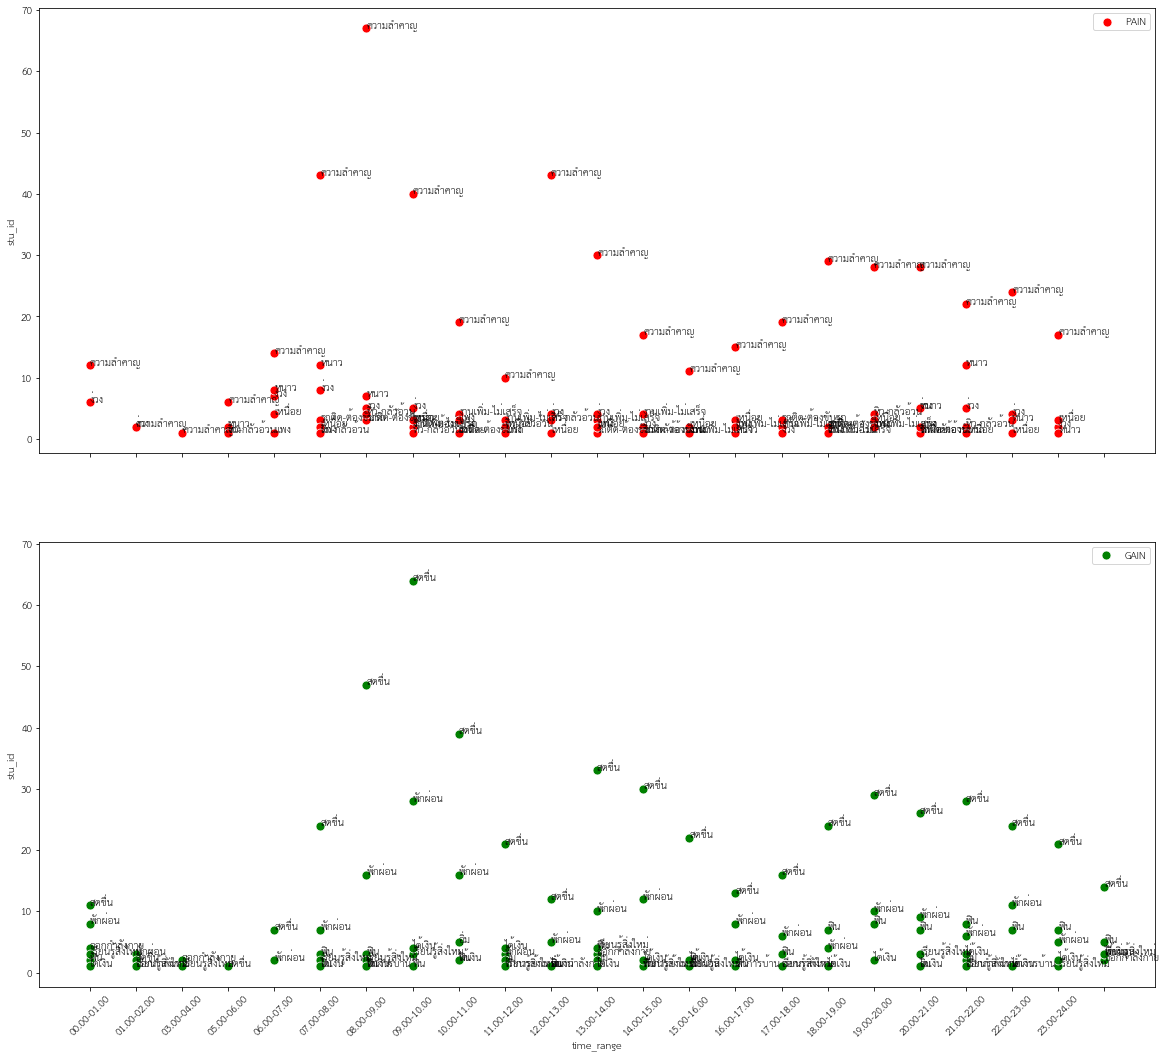

In [33]:
fig, ax = plt.subplots(2,1,figsize =(20,18), sharex =True, sharey=True)
sns.scatterplot(x='time_range', y='stu_id', 
                data = df_day_pain, ax=ax[0], 
                s= 80, label = 'PAIN',
                color ='r')
sns.scatterplot(x='time_range', y='stu_id', data = df_day_gain, ax=ax[1], s= 80, label = 'GAIN', color='green')

for i in df_day_pain.index:
  ax[0].annotate(df_day_pain.loc[i,'group_pain'], (df_day_pain.loc[i,'time_range'], df_day_pain.loc[i,'stu_id']))

for i in df_day_gain.index:
  ax[1].annotate(df_day_gain.loc[i,'group_gain'], (df_day_gain.loc[i,'time_range'], df_day_gain.loc[i,'stu_id']))

ax[1].set_xticklabels(df_day_pain['time_range'].unique(),rotation=45)
plt.show()

## Write file

In [34]:
df_day_gain.to_csv('/content/drive/MyDrive/CRM_Analytics/hw03-value_proposition/daily_gain.csv',index=False)
df_day_pain.to_csv('/content/drive/MyDrive/CRM_Analytics/hw03-value_proposition/daily_pain.csv',index=False)
df_day.to_csv('/content/drive/MyDrive/CRM_Analytics/hw03-value_proposition/daily_all.csv', index=False)
wake2sleep.to_csv('/content/drive/MyDrive/CRM_Analytics/hw03-value_proposition/wake2sleep.csv',index=False)

In [35]:
# use for tree decomposition in power bi
df_pain_pv = df_day[df_day['group_pain']!='ไม่ระบุ'].pivot_table(index='stu_id', columns = 'activity_num',values = 'group_pain', aggfunc = 'sum')
df_gain_pv = df_day[df_day['group_gain']!='ไม่ระบุ'].pivot_table(index='stu_id', columns = 'activity_num',values = 'group_gain', aggfunc = 'sum')
df_pain_pv.to_csv('/content/drive/MyDrive/CRM_Analytics/hw03-value_proposition/df_pain_pv.csv')
df_gain_pv.to_csv('/content/drive/MyDrive/CRM_Analytics/hw03-value_proposition/df_gain_pv.csv')